In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as LA
import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import matplotlib as mpl

import MAC_functions_conducting_core as mf
import MAC_plotting as mplt
import MAC_logging as mlog

from numpy import sin
from numpy import cos
import sys
from datetime import datetime
import cPickle as pkl
import os
%matplotlib inline

In [2]:
######################################################################
##########	Define Parameters	######################################
######################################################################

######################################################################
#### Edit These: ####

# mode to simulate
m = 0

# Size of grid
Nk = 10
Nl = 200
Nm = 1

# Set up variables to use
model_variables = ('ur','uth','uph','br','bth','bph','p','r_disp')
boundary_variables = ('ur','uth','uph','br','bth','bph','p')

# Physical Constants
R = 3480e3 # Outer core radius in m
Omega = 2*np.pi/(24.0*3600.0) # rotation rate in rad/s
rho = 1.e4	# density in kg/m^3
h = 80e3 # layer thickness in m
nu = 1. # momentum diffusivity in m^2/s
eta = 2. # magnetic diffusivity in m^2/s
mu_0 = 4.*np.pi*10.**-7 # vacuum permeability in (kg*m/(A^2s^2))
g = 10. # Gravity in m/s^2
drho_dr = -1e-1 # density gradient for boussinesq approximation in kg/m^4 (constant gradient in this model)
omega_g = 2*Omega # Buoyancy frequency in rad/s
T1 = 65.0*365.25*24*3600 # Period of first mode in seconds
Bd = (0.446e-2)*(4*np.pi*rho)**0.5*(mu_0/(4*np.pi))**0.5  # Dipole Field constant in Teslas (Bd = Br*cos(theta))
delta_C = np.sqrt(2*nu/(2*np.pi/T1))  # Core magnetic skin depth for first mode

### Parameters to set for automated run####
# sigmas = 10.**np.linspace(-4,-7,1)*1j
num_eigs =20
max_iter = 2000
which = 'LI'
dir_name = './output/automated_run_{0}_{1}/'.format(datetime.today().date(),datetime.today().time())
tol = 1e-5
####
#### End Editable parameters ####
######################################################################


# Calculate Non-Dimensionalized Parameters
t_star = 1/Omega  # seconds
r_star = R	# meters
P_star = rho* r_star**2/t_star**2
B_star = (eta*mu_0*rho/t_star)**0.5
u_star = r_star/t_star
E = nu*t_star/r_star**2
Prm = nu/eta
G = (omega_g*t_star)**2
l1 = 2*np.pi/(T1/t_star)

######################## Important: LOOK HERE! #################
sigmas = [l1*1j*0.1, l1*1j*0.5, l1*1.0j]
################################################################

physical_constants = {'R':R,'Omega':Omega,'rho':rho,'h':h,'nu':nu,'eta':eta,'mu_0':mu_0,'omega_g':omega_g,'Bd':Bd,
					  't_star':t_star,'r_star':r_star,'u_star':u_star,'P_star':P_star,'B_star':B_star,
					  'E':E,'Prm':Prm,'G':G,'l1':l1,'delta_C':delta_C}

# Create model parameter vectors
SizeM = len(model_variables)*Nk*Nl+2*len(boundary_variables)*Nl
rmin = (R-h)/r_star
rmax = R/r_star
dr = (rmax-rmin)/(Nk)
r = np.linspace(rmin-dr/2.,rmax+dr/2.,num=Nk+2.) # r value at center of each cell
rm = np.linspace(rmin-dr,rmax,num=Nk+2.) # r value at plus border (top) of cell
rp = np.linspace(rmin,rmax+dr,num=Nk+2.) # r value at minus border (bottom) of cell
dth = np.pi/(Nl)
th = np.linspace(-dth/2.,np.pi+dth/2.,num=Nl+2.) # theta value at center of cell
thm = np.linspace(-dth,np.pi,num=Nl+2.) # theta value at plus border (top) of cell
thp = np.linspace(0,np.pi+dth,num=Nl+2.) # theta value at minus border (bottom) of cell
m_min = m
m_max = m
m_values = range(m_min,m_max+1)

### Set Background Fields
B0 = np.ones((Nk+2,Nl+2))*cos(th)*Bd/B_star
U0 = np.ones((Nk+2,Nl+2))*1e-16

model_parameters = {'Nk':Nk,'Nl':Nl,'Nm':Nm,'SizeM':SizeM,
					'dr':dr,'r':r,'rm':rm,'rp':rp,
					'dth':dth,'th':th,'thm':thm,'thp':thp,
					'm_values':m_values,
					'B0':B0, 'U0':U0
				   }


######################################################################
##########	Create Model   ###########################################
######################################################################
model = mf.ModelBraginskyConductingCore(model_variables,boundary_variables,physical_constants,model_parameters)

A_matrices = {}
M_matrices = {}
model.make_A(m)
model.make_M(m)



<18800x18800 sparse matrix of type '<type 'numpy.int64'>'
	with 6000 stored elements in Compressed Sparse Row format>

In [3]:
######################################################################
# SLEPc Test
######################################################################

# Import PETSc, SLEPc and initialize
import sys, slepc4py
slepc4py.init(sys.argv)
from petsc4py import PETSc
from slepc4py import SLEPc


# Set up A matrix 
opts = PETSc.Options()
A = PETSc.Mat()
A.create()
A.setSizes([model.SizeM, model.SizeM])
A.setFromOptions()
A.setUp()
for key,val in model.A.todok().iteritems():
    A[key[0], key[1]] = val
A.assemble()

# Set up M matrix
M = PETSc.Mat()
M.create()
M.setSizes([model.SizeM, model.SizeM])
M.setFromOptions()
M.setUp()
for key,val in model.M.todok().iteritems():
    M[key[0], key[1]] = val
M.assemble()

In [4]:
# Solve Eigenvalue Problem
E = SLEPc.EPS()
E.create()
E.setDimensions(nev=3)
E.setOperators(A,M)
E.setProblemType(SLEPc.EPS.ProblemType.GNHEP)

E.setFromOptions()
which=E.Which.TARGET_IMAGINARY
E.setWhichEigenpairs(which)
sigma=l1*1j
E.setTarget(sigma)
E.setType(E.Type.KRYLOVSCHUR)

In [5]:
E.solve()

In [6]:
## Print Results
print "******************************"
print "*** SLEPc Solution Results ***"
print "******************************\n"


print 'Requested Sigma: {0}'.format(sigma)
its = E.getIterationNumber()
print 'Number of iterations of the method: {0}'.format( its)

eps_type = E.getType()
print "Solution method: {0}".format( eps_type)

nev, ncv, mpd = E.getDimensions()
print "Number of requested eigenvalues: {0}".format( nev)

tol, maxit = E.getTolerances()
print "Stopping condition: tol={0}, maxit={1}".format(tol, maxit)

nconv = E.getConverged()
print "Number of converged eigenpairs: {0}".format( nconv)

vecs ={}
if nconv > 0:
    # Create the results vectors
    v, w = A.getVecs()

    #
    print "                k                     ||Ax-kx||/||kx|| "
    for i in range(nconv):
        k = E.getEigenpair(i, w)
        error = E.computeRelativeError(i)
        print " {0} +- {1}".format(k, error)
        vecs[i]=w.getArray()


******************************
*** SLEPc Solution Results ***
******************************

Requested Sigma: 4.21207813405e-05j
Number of iterations of the method: 2088
Solution method: krylovschur
Number of requested eigenvalues: 3
Stopping condition: tol=1e-08, maxit=2088
Number of converged eigenpairs: 2
                k                     ||Ax-kx||/||kx|| 
 (-198.121156542+0.0487963165419j) +- 8.0787762257e-14
 (-198.121156542-0.0487963165417j) +- 1.00015217049e-13


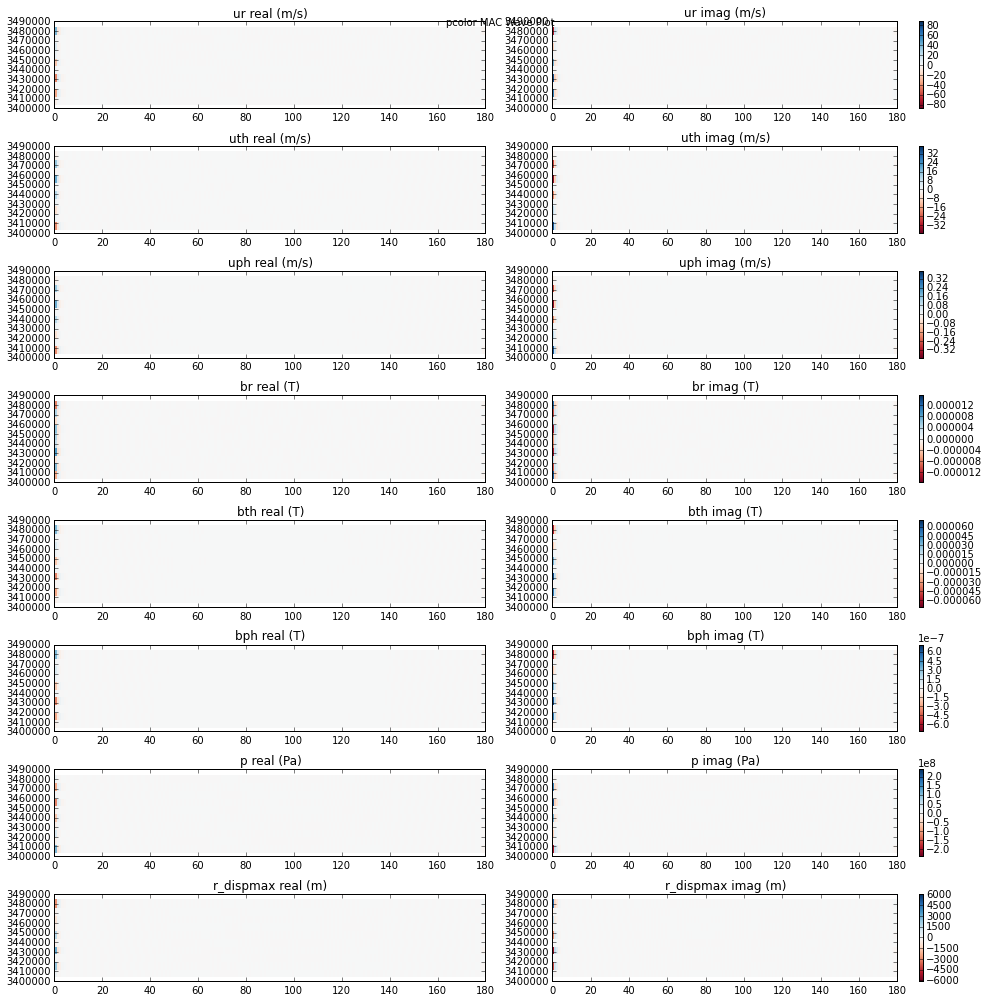

In [7]:
ind=0
mplt.plot_pcolor_rth(model,ind,vecs[ind])